# Requiements

In [13]:
!pip install split_folders
!pip install seaborn
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install opencv-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-3r3gpqt8
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-3r3gpqt8


In [30]:
import os
import splitfolders
import albumentations as A
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras import backend as K 

# Dataset Preparation

## Import Dataset from Google Drive

In [31]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!cp '/content/drive/MyDrive/Colab Notebooks/Data.zip' '/content/'
!mkdir data
!unzip -o /content/Data.zip -d data/

mkdir: cannot create directory ‘data’: File exists
Archive:  /content/Data.zip
  inflating: data/G1/G10000.tif      
  inflating: data/G1/G10001.tif      
  inflating: data/G1/G10002.tif      
  inflating: data/G1/G10003.tif      
  inflating: data/G1/G10004.tif      
  inflating: data/G1/G10005.tif      
  inflating: data/G1/G10006.tif      
  inflating: data/G1/G10007.tif      
  inflating: data/G1/G10008.tif      
  inflating: data/G1/G10009.tif      
  inflating: data/G1/G10010.tif      
  inflating: data/G1/G10011.tif      
  inflating: data/G1/G10012.tif      
  inflating: data/G1/G10013.tif      
  inflating: data/G1/G10014.tif      
  inflating: data/G1/G10015.tif      
  inflating: data/G1/G10016.tif      
  inflating: data/G1/G10017.tif      
  inflating: data/G1/G10018.tif      
  inflating: data/G1/G10019.tif      
  inflating: data/G1/G10020.tif      
  inflating: data/G1/G10021.tif      
  inflating: data/G1/G10022.tif      
  inflating: data/G1/G10023.tif      
  inflati

In [17]:
image_directory = '/content/data/'
data = os.listdir(image_directory)

## Image Augmentation

In [18]:
transform = A.Compose([
    A.ToFloat(max_value=65535.0),

    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(p=0.2),
    #A.OneOf([
    #    A.MotionBlur(p=0.2),
    #    A.MedianBlur(blur_limit=3, p=0.1),
    #    A.Blur(blur_limit=3, p=0.1),
    #], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    #A.OneOf([
    #    A.OpticalDistortion(p=0.3),
    #    A.GridDistortion(p=0.1),
    #], p=0.2),        
    #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.3),

    A.FromFloat(max_value=65535.0),
])

## Dataset Splitting

In [19]:
path_original = '/content/data/'
path_split = "/content/data_split/"
splitfolders.ratio(path_original, path_split, seed=42, ratio=(.7, .15, .15)) 

Copying files: 1195 files [00:00, 6145.95 files/s]


In [20]:
folder_g1_train = "/content/data_split/train/G1"
folder_g2_train = "/content/data_split/train/G2"
folder_s_train = "/content/data_split/train/S"

folder_g1_test = "/content/data_split/test/G1"
folder_g2_test = "/content/data_split/test/G2"
folder_s_test = "/content/data_split/test/S"

folder_g1_val = "/content/data_split/val/G1"
folder_g2_val = "/content/data_split/val/G2"
folder_s_val = "/content/data_split/val/S"

"""
folder_g1_train = "/content/data_split/train/G1"
folder_g2_train = "/content/data_split/train/G2"
folder_s_train = "/content/data_split/train/S"

folder_g1_test = "/content/data_split/test/G1"
folder_g2_test = "/content/data_split/test/G2"
folder_s_test = "/content/data_split/test/S"

folder_g1_val = "/content/data_split/val/G1"
folder_g2_val = "/content/data_split/val/G2"
folder_s_val = "/content/data_split/val/S"
"""

## using opencv instead
##read = lambda imname: np.asarray(Image.open(imname).convert("I;16"))

##read = lambda imname: np.asarray(cv2.imread(imname, cv2.IMREAD_UNCHANGED))
#transformed_image_1 = transform(image=image)['image']

read = lambda imname: np.asarray(cv2.imread(imname, cv2.IMREAD_UNCHANGED))
read_augmented = lambda imname: transform(image=cv2.imread(imname, cv2.IMREAD_UNCHANGED))['image']

# Load in training pictures 
imgs_g1_train = [read(os.path.join(folder_g1_train, filename)) for filename in os.listdir(folder_g1_train)]
X_G1_train = np.array(imgs_g1_train, dtype='uint16')
imgs_g2_train = [read(os.path.join(folder_g2_train, filename)) for filename in os.listdir(folder_g2_train)]
X_G2_train = np.array(imgs_g2_train, dtype='uint16')
imgs_s_train = [read(os.path.join(folder_s_train, filename)) for filename in os.listdir(folder_s_train)]
X_S_train = np.array(imgs_s_train, dtype='uint16')


# Load in testing pictures
imgs_g1_test = [read(os.path.join(folder_g1_test, filename)) for filename in os.listdir(folder_g1_test)]
X_G1_test = np.array(imgs_g1_test, dtype='uint16')
imgs_g2_test = [read(os.path.join(folder_g2_test, filename)) for filename in os.listdir(folder_g2_test)]
X_G2_test = np.array(imgs_g2_test, dtype='uint16')
imgs_s_test = [read(os.path.join(folder_s_test, filename)) for filename in os.listdir(folder_s_test)]
X_S_test = np.array(imgs_s_test, dtype='uint16')

# Load in val pictures
imgs_g1_val = [read(os.path.join(folder_g1_val, filename)) for filename in os.listdir(folder_g1_val)]
X_G1_val = np.array(imgs_g1_val, dtype='uint16')
imgs_g2_val = [read(os.path.join(folder_g2_val, filename)) for filename in os.listdir(folder_g2_val)]
X_G2_val = np.array(imgs_g2_val, dtype='uint16')
imgs_s_val = [read(os.path.join(folder_s_val, filename)) for filename in os.listdir(folder_s_val)]
X_S_val = np.array(imgs_s_val, dtype='uint16')


print(X_G1_train.shape)
print(X_G2_train.shape)

(304, 128, 128)
(244, 128, 128)


# Training

In [21]:
minElement = np.amin(X_G1_train.shape)
print('Minimum element from Numpy Array : ', minElement)
maxElement = np.amax(X_G1_train)
print('Maximum element from Numpy Array : ', maxElement)
#X_G1_train.shape
#X_G2_train.shape
#X_S_train.shape
304+244+287

Minimum element from Numpy Array :  128
Maximum element from Numpy Array :  5742


835

In [22]:
# Create labels
y_G1_train = np.zeros(X_G1_train.shape[0])
y_G2_train = np.ones(X_G2_train.shape[0])
y_S_train = np.ones(X_S_train.shape[0])

y_G1_test = np.zeros(X_G1_test.shape[0])
y_G2_test = np.ones(X_G2_test.shape[0])
y_S_test = np.ones(X_S_test.shape[0])

y_G1_val = np.zeros(X_G1_val.shape[0])
y_G2_val = np.ones(X_G2_val.shape[0])
y_S_val = np.ones(X_S_val.shape[0])


# Merge data 
X_train = np.concatenate((X_G1_train, X_G2_train, X_S_train), axis = 0)
y_train = np.concatenate((y_G1_train, y_G2_train, y_S_train), axis = 0)

X_test = np.concatenate((X_G1_test, X_G2_test, X_S_test), axis = 0)
y_test = np.concatenate((y_G1_test, y_G2_test, y_S_test), axis = 0)

X_val = np.concatenate((X_G1_val, X_G2_val, X_S_val), axis = 0)
y_val = np.concatenate((y_G1_val, y_G2_val, y_S_val), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

s = np.arange(X_val.shape[0])
np.random.shuffle(s)
X_val = X_val[s]
y_val = y_val[s]

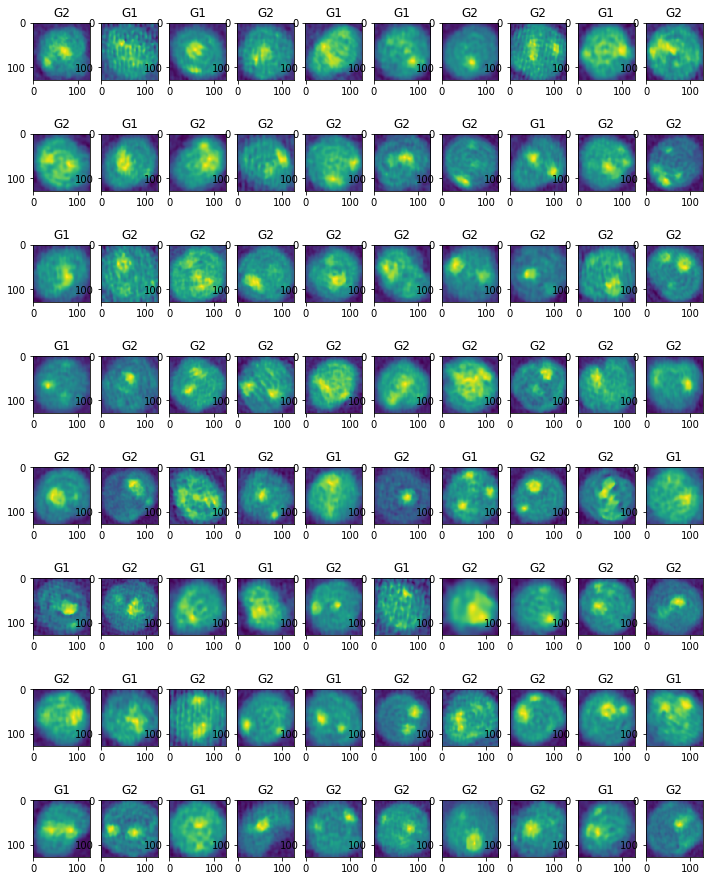

In [23]:
w=320
h=480
fig=plt.figure(figsize=(12, 16))
columns = 10
rows = 8

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('G1')
    else:
        ax.title.set_text('G2')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [24]:
y_train = to_categorical(y_train, num_classes= 3)
y_test = to_categorical(y_test, num_classes= 3)
y_val = to_categorical(y_val, num_classes= 3)

In [25]:
# Fit to value between 0 and 1???
#X_train = X_train/255.
#X_test = X_test/255.
#X_val = X_val/255.

X_train = (X_train) /65536.
X_test = (X_test) /65536.
X_val = (X_val) /65536.

In [26]:
minElement = np.amin(X_train)
print('Minimum element from Numpy Array : ', minElement)
maxElement = np.amax(X_train)
print('Maximum element from Numpy Array : ', maxElement)
X_train.shape

Minimum element from Numpy Array :  0.004547119140625
Maximum element from Numpy Array :  0.087615966796875


(835, 128, 128)

In [27]:
X_train=X_train.reshape(835,128,128,1)

In [28]:
def build(input_shape= (128,128,1), lr = 1e-5, num_classes= 3,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(400, kernel_size=(8, 8),padding = 'Same',input_shape=input_shape, activation= activ, kernel_initializer='glorot_uniform',data_format='channels_last'))
    model.add(MaxPool2D(pool_size = (7, 7),data_format='channels_last'))
    model.add(Dropout(0.25))

    model.add(Conv2D(100, kernel_size=(5, 5),padding = 'Same', activation =activ, kernel_initializer = 'glorot_uniform',input_shape=input_shape))
    model.add(MaxPool2D(pool_size = (6, 6),data_format='channels_last'))
    model.add(Dropout(0.25))

    model.add(Conv2D(50, kernel_size=(2, 2),padding = 'Same', activation =activ, kernel_initializer = 'glorot_uniform',input_shape=input_shape))
    model.add(Conv2D(150, kernel_size=(3, 3),padding = 'Same', activation =activ, kernel_initializer = 'glorot_uniform',input_shape=input_shape))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)

    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [29]:
input_shape = (128,128,1)
learning_rate = 1e-7
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=learning_rate, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 400)     26000     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 400)       0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 400)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 100)       1000100   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 100)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 100)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 50)          2

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


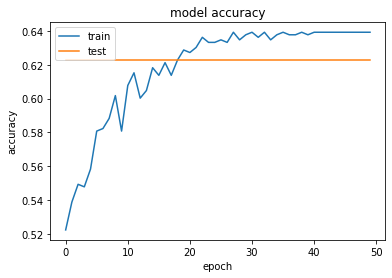

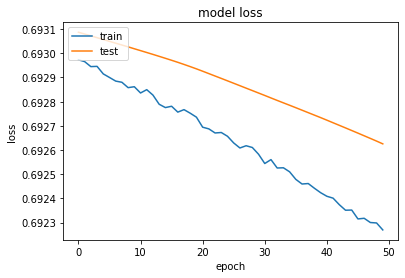

In [ ]:
## PLOTTING
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test','val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'val'], loc='upper left')
plt.show()

In [ ]:
history.history


{'accuracy': [0.522455096244812,
  0.538922131061554,
  0.5494012236595154,
  0.5479041934013367,
  0.5583832263946533,
  0.5808383226394653,
  0.582335352897644,
  0.5883233547210693,
  0.6017963886260986,
  0.5808383226394653,
  0.6077844500541687,
  0.6152694821357727,
  0.6002994179725647,
  0.6047903895378113,
  0.6182634830474854,
  0.613772451877594,
  0.621257483959198,
  0.613772451877594,
  0.6227545142173767,
  0.628742516040802,
  0.6272454857826233,
  0.6302395462989807,
  0.636227548122406,
  0.6332335472106934,
  0.6332335472106934,
  0.6347305178642273,
  0.6332335472106934,
  0.6392215490341187,
  0.6347305178642273,
  0.6377245783805847,
  0.6392215490341187,
  0.636227548122406,
  0.6392215490341187,
  0.6347305178642273,
  0.6377245783805847,
  0.6392215490341187,
  0.6377245783805847,
  0.6377245783805847,
  0.6392215490341187,
  0.6377245783805847,
  0.6392215490341187,
  0.6392215490341187,
  0.6392215490341187,
  0.6392215490341187,
  0.6392215490341187,
  0.639

In [ ]:
input_shape = (128,128,1)
lr = 1e-5
epochs = 50
batch_size = 64

model = VGG19 (include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=3)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.8,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )





Epoch 1/50
3/3 - 24s - loss: 0.6931 - accuracy: 0.5482 - val_loss: 0.6928 - val_accuracy: 0.6278
Epoch 2/50
3/3 - 21s - loss: 0.6927 - accuracy: 0.6687 - val_loss: 0.6924 - val_accuracy: 0.6278
Epoch 3/50
3/3 - 21s - loss: 0.6922 - accuracy: 0.6687 - val_loss: 0.6919 - val_accuracy: 0.6278
Epoch 4/50
3/3 - 21s - loss: 0.6917 - accuracy: 0.6687 - val_loss: 0.6914 - val_accuracy: 0.6278
Epoch 5/50
3/3 - 21s - loss: 0.6911 - accuracy: 0.6687 - val_loss: 0.6906 - val_accuracy: 0.6278
Epoch 6/50
3/3 - 21s - loss: 0.6902 - accuracy: 0.6687 - val_loss: 0.6895 - val_accuracy: 0.6278

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 7/50
3/3 - 20s - loss: 0.6892 - accuracy: 0.6687 - val_loss: 0.6888 - val_accuracy: 0.6278
Epoch 8/50
3/3 - 20s - loss: 0.6884 - accuracy: 0.6687 - val_loss: 0.6879 - val_accuracy: 0.6278
Epoch 9/50
3/3 - 20s - loss: 0.6873 - accuracy: 0.6687 - val_loss: 0.6866 - val_accuracy: 0.6278
Epoch 10/50
3/3 - 21s - loss: 0.6858 - accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


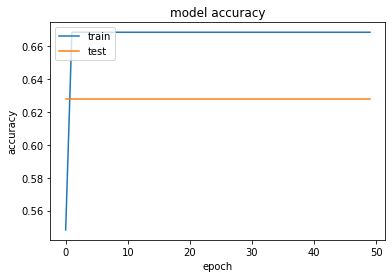

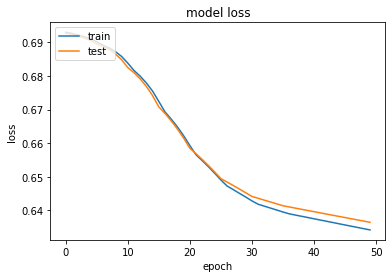

In [ ]:


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 400)     26000     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 400)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 18, 18, 400)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 18, 100)       1000100   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 100)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 3, 100)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 50)         

In [ ]:
K.clear_session()
del model
del history

# New Section